# LIBRARIES

In [ ]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Image processing libraries
import cv2
import skimage
from skimage.transform import resize

# Scikit-learn for machine learning operations
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Metrics for evaluation
from sklearn import metrics


# DATA LOADING AND PREPROCESSING

In [ ]:
#Load the Dataset
dataset_path = "/content/Indian"
class_names = sorted(os.listdir('/content/Indian'))

In [ ]:
from os import listdir
total_signs=sorted(listdir("/content/Indian"))
print(total_signs)

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
import os
from collections import defaultdict
from matplotlib.image import imread

path = "/content/Indian"
total_signs = os.listdir(path)

resolution_count = defaultdict(int)

for directory in total_signs:
    directory_path = os.path.join(path, directory)
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        try:
            img = imread(image_path)
            resolution = img.shape[:2]  # Extract resolution (height, width)
            resolution_count[resolution] += 1
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

print("Resolution Counts:")
for resolution, count in resolution_count.items():
    print(f"Resolution: {resolution}, Count: {count}")


Resolution Counts:
Resolution: (128, 128), Count: 42000
Resolution: (480, 640), Count: 476
Resolution: (1088, 1920), Count: 90
Resolution: (1920, 1088), Count: 179


In [ ]:
import pandas as pd
import os

# Define the base directory
train_folder = "/content/Indian"


# Constructing a list of dictionaries containing file paths and corresponding labels
all_data = [{'label': folder, 'path': os.path.join(train_folder, folder, f)}
            for folder in os.listdir(train_folder)
            for f in os.listdir(os.path.join(train_folder, folder))
            if os.path.isfile(os.path.join(train_folder, folder, f))]

# Creating a DataFrame from the list of dictionaries
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,P,/content/Indian/P/797.jpg
1,P,/content/Indian/P/603.jpg
2,P,/content/Indian/P/1148.jpg
3,P,/content/Indian/P/749.jpg
4,P,/content/Indian/P/509.jpg
...,...,...
42740,F,/content/Indian/F/618.jpg
42741,F,/content/Indian/F/549.jpg
42742,F,/content/Indian/F/289.jpg
42743,F,/content/Indian/F/244.jpg


In [ ]:
train_data, test_data = train_test_split(data_df, test_size=0.1, random_state=42, stratify=data_df['label'])
train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])

# Display the number of samples in each set
print("Training samples:", len(train_data))
print("Validation samples:", len(validation_data))
print("Test samples:", len(test_data))

Training samples: 30776
Validation samples: 7694
Test samples: 4275


In [ ]:
# Define image dimensions and batch size
img_width, img_height = 128, 128
batch_size = 64

# Define column names
y_col = 'label'
x_col = 'path'

# Number of classes
no_of_classes = len(data_df[y_col].unique())

# Image data generators
datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Flow from dataframe for training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

# Flow from dataframe for test data
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)
test_datagen = ImageDataGenerator(rescale=1./255)
# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='path',
    y_col='label',
    target_size=(img_width, img_height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 30776 validated image filenames belonging to 35 classes.
Found 7694 validated image filenames belonging to 35 classes.
Found 4275 validated image filenames belonging to 35 classes.


# CUSTOM CNN

In [ ]:
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential()

cnn_model.add(Conv2D(24,(3,3),activation="relu",input_shape=(img_width, img_height, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(64,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Conv2D(128,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Conv2D(256,(3,3),activation="relu",padding="same"))
cnn_model.add(Dropout(0.3))
cnn_model.add(MaxPooling2D((2,2),strides=2))

cnn_model.add(Flatten())
cnn_model.add(Dense(2352,activation="relu"))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(35,activation="softmax"))

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 24)      672       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 24)      96        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 24)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        13888     
                                                                 
 dropout (Dropout)           (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0

In [ ]:
# Define parameters
learning_rate = 0.0001

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = cnn_model.fit(train_generator,
                    epochs=10,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[Early_Stopper,Checkpoint_Model],
                    shuffle=True)

Epoch 1/10
481/481 [==============================] - 93s 189ms/step - loss: 0.0410 - accuracy: 0.9867 - val_loss: 0.1724 - val_accuracy: 0.9944
Epoch 2/10
481/481 [==============================] - 91s 190ms/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.1850 - val_accuracy: 0.9977
Epoch 3/10
481/481 [==============================] - 91s 189ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.1616 - val_accuracy: 0.9918
Epoch 4/10
481/481 [==============================] - 91s 189ms/step - loss: 0.0160 - accuracy: 0.9951 - val_loss: 0.0965 - val_accuracy: 0.9988
Epoch 5/10
481/481 [==============================] - 91s 189ms/step - loss: 0.0122 - accuracy: 0.9964 - val_loss: 0.0772 - val_accuracy: 0.9986
Epoch 6/10
481/481 [==============================] - 90s 188ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0553 - val_accuracy: 0.9997
Epoch 7/10
481/481 [==============================] - 91s 189ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0668 - val_ac

In [ ]:
cnn_model.save('35-cnn-newisl.h5')

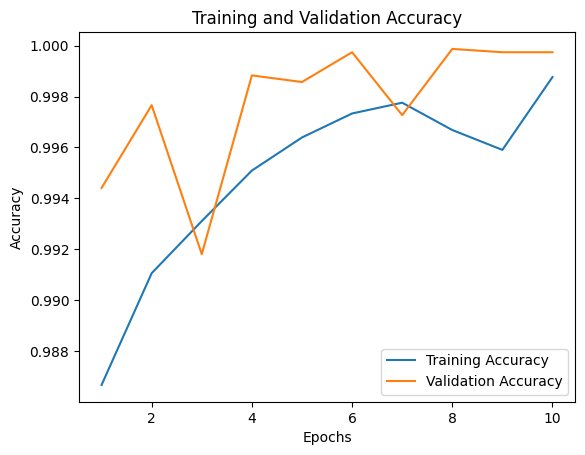

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


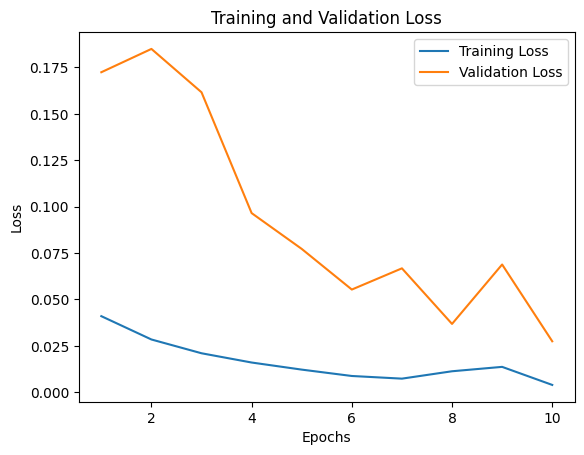

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score

# Generate predictions on test data
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes) * 100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted') * 100
recall = recall_score(true_classes, predicted_classes, average='weighted') * 100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


67/67 [==============================] - 3s 36ms/step
Accuracy: 100.0
Precision: 100.0
Recall: 100.0
F1-score: 100.0


67/67 [==============================] - 2s 27ms/step


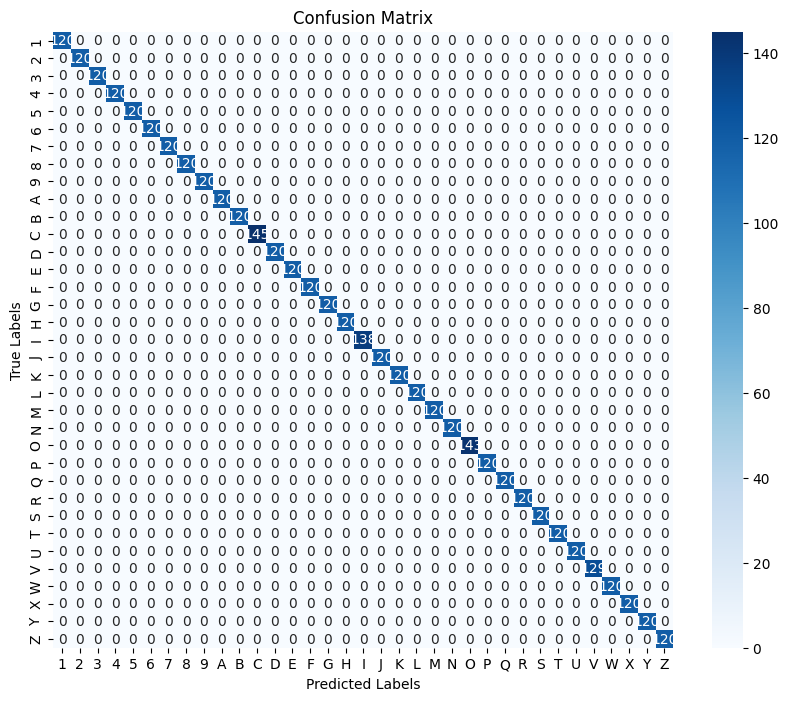

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have already trained your model and stored it in a variable named 'model'

# Generate predictions
predictions = cnn_model.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from test_generator
true_labels = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 360ms/step


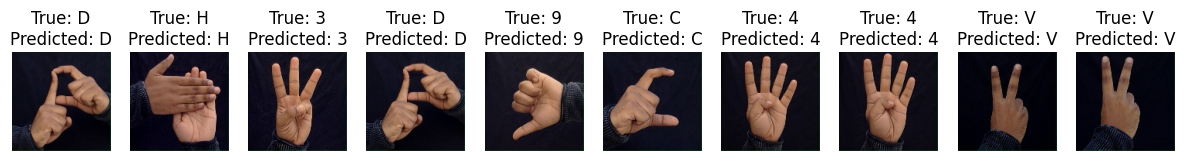

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = cnn_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# INCEPTIONV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
# Load the  inceptionv3 model pre-trained on ImageNet without the top layer
base_model1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers
base_model1.trainable = False

# Print model summary
base_model1.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 63, 63, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 63, 63, 32)           96        ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 63, 63, 32)           0         ['batch_normalizati

In [ ]:

inceptionv3_model = models.Sequential([
    base_model1,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])


In [ ]:
inceptionv3_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 35)                17955     
                                                                 
Total params: 26015555 (99.24 MB)
Trainable params: 4212771 (16.07 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
inceptionv3_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history1 = inceptionv3_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
481/481 [==============================] - 93s 188ms/step - loss: 0.0511 - accuracy: 0.9843 - val_loss: 0.0097 - val_accuracy: 0.9966
Epoch 2/10
481/481 [==============================] - 89s 186ms/step - loss: 0.0434 - accuracy: 0.9866 - val_loss: 0.0100 - val_accuracy: 0.9968
Epoch 3/10
481/481 [==============================] - 89s 186ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.0058 - val_accuracy: 0.9978
Epoch 4/10
481/481 [==============================] - 90s 186ms/step - loss: 0.0427 - accuracy: 0.9874 - val_loss: 0.0101 - val_accuracy: 0.9970
Epoch 5/10
481/481 [==============================] - 89s 185ms/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0069 - val_accuracy: 0.9979
Epoch 6/10
481/481 [==============================] - 89s 186ms/step - loss: 0.0377 - accuracy: 0.9883 - val_loss: 0.0085 - val_accuracy: 0.9973
Epoch 7/10
481/481 [==============================] - 88s 184ms/step - loss: 0.0335 - accuracy: 0.9897 - val_loss: 0.0081 - val_ac

In [ ]:
inceptionv3_model.save('35-inceptionv3-newisl.h5')

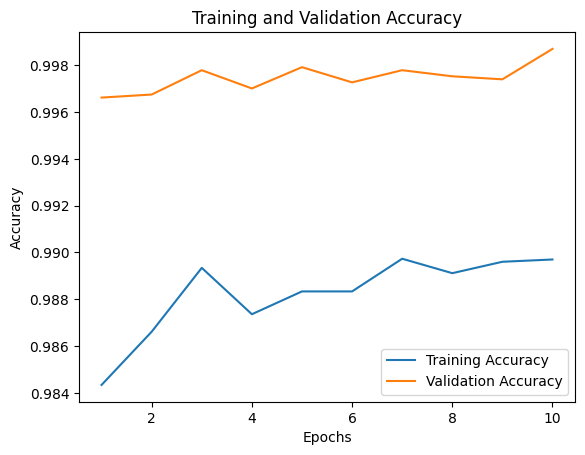

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

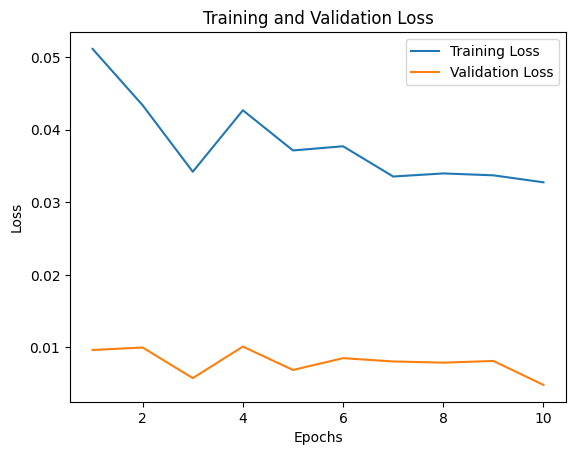

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = inceptionv3_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


67/67 [==============================] - 5s 65ms/step
Accuracy: 99.71929824561403
Precision: 99.73928463880615
Recall: 99.71929824561403
F1-score: 99.72929044085956


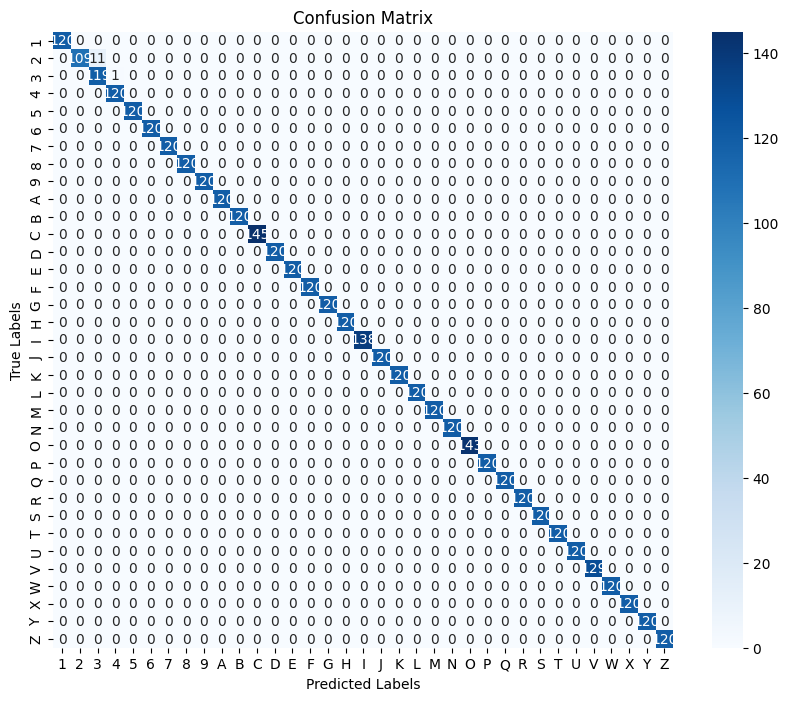

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


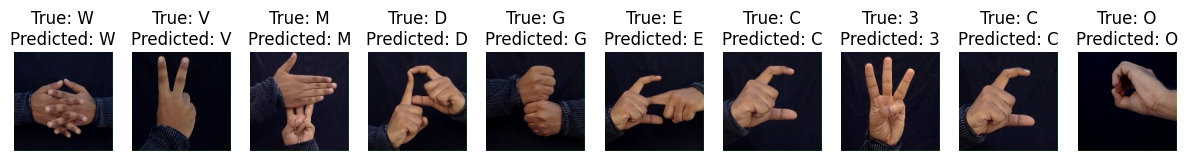

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MOBILENETV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
# Load the MobileNetV2 model pre-trained on ImageNet without the top layer
base_model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model2.trainable = False
# Print model summary
base_model2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [ ]:
MobileNetV2_model = models.Sequential([
    base_model2,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])

In [ ]:
MobileNetV2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_4 (Flatten)         (None, 20480)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               10486272  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 35)                17955     
                                                                 
Total params: 12762211 (48.68 MB)
Trainable params: 10504227 (40.07 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
MobileNetV2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = MobileNetV2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
481/481 [==============================] - 87s 178ms/step - loss: 0.1790 - accuracy: 0.9551 - val_loss: 0.0044 - val_accuracy: 0.9987
Epoch 2/10
481/481 [==============================] - 91s 188ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0019 - val_accuracy: 0.9996
Epoch 3/10
481/481 [==============================] - 91s 190ms/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.0023 - val_accuracy: 0.9987
Epoch 4/10
481/481 [==============================] - 89s 186ms/step - loss: 0.0156 - accuracy: 0.9948 - val_loss: 0.0024 - val_accuracy: 0.9994
Epoch 5/10
481/481 [==============================] - 89s 185ms/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 3.3905e-04 - val_accuracy: 0.9999
Epoch 6/10
481/481 [==============================] - 91s 189ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 5.2227e-04 - val_accuracy: 0.9997
Epoch 7/10
481/481 [==============================] - 89s 186ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 0.0012 

In [ ]:
MobileNetV2_model.save('35-mobilenetv2-newisl.h5')

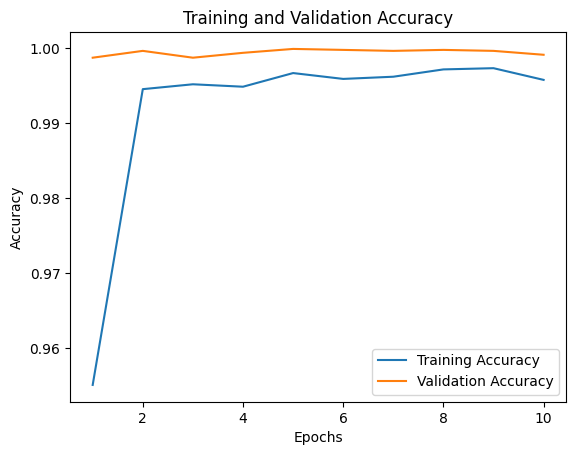

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


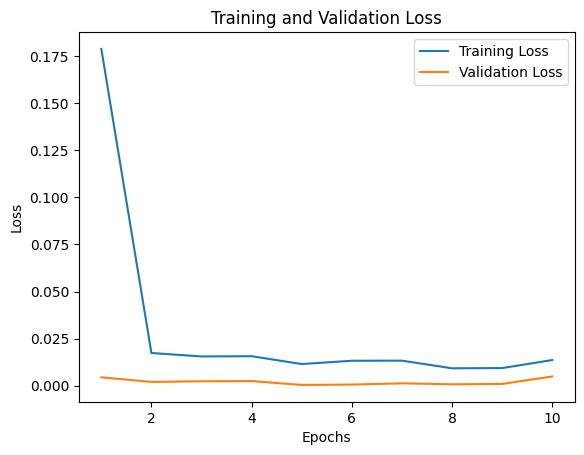

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Generate predictions on test data
predictions = MobileNetV2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


67/67 [==============================] - 3s 30ms/step
Accuracy: 100.0
Precision: 100.0
Recall: 100.0
F1-score: 100.0


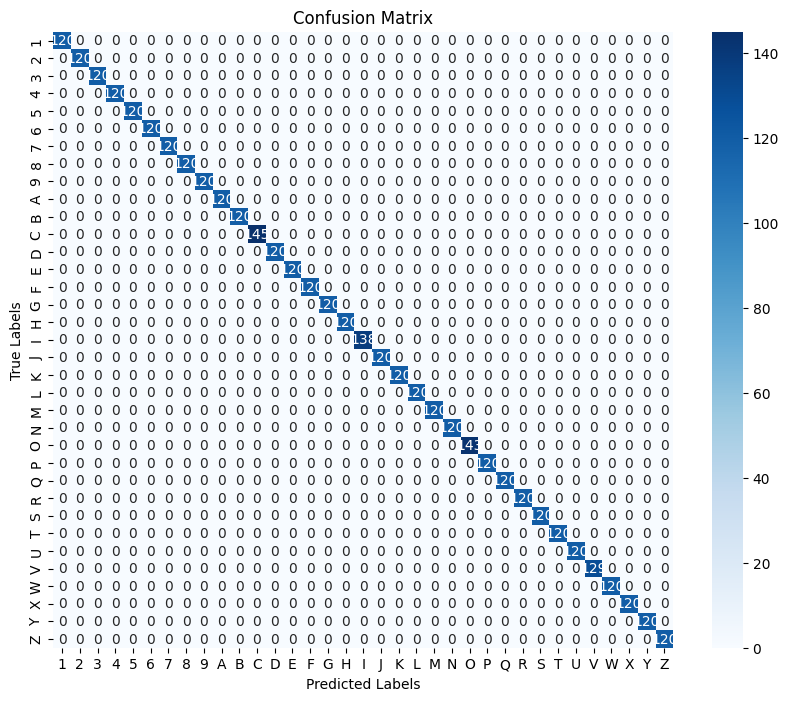

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 24ms/step


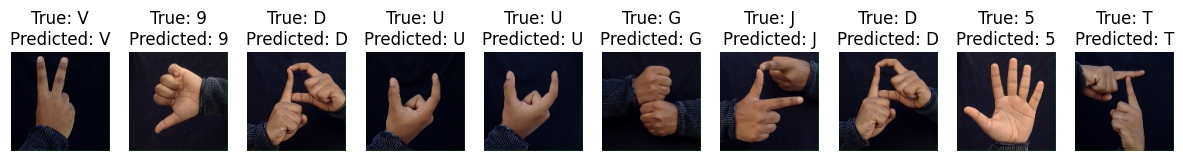

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = inceptionv3_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# RESNET50V2

In [ ]:
from tensorflow.keras.applications import ResNet50V2
# Load the ResNet50 model pre-trained on ImageNet without the top layer
base_model3 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model3.trainable = False
# Print model summary
base_model3.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 66, 66, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
ResNet50V2_model = models.Sequential([
    base_model3,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])

In [ ]:
ResNet50V2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 35)                17955     
                                                                 
Total params: 40360483 (153.96 MB)
Trainable params: 16795683 (64.07 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
ResNet50V2_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history3 = ResNet50V2_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
481/481 [==============================] - 93s 189ms/step - loss: 0.1515 - accuracy: 0.9571 - val_loss: 0.0241 - val_accuracy: 0.9922
Epoch 2/10
481/481 [==============================] - 93s 193ms/step - loss: 0.0581 - accuracy: 0.9838 - val_loss: 0.0077 - val_accuracy: 0.9975
Epoch 3/10
481/481 [==============================] - 93s 193ms/step - loss: 0.0469 - accuracy: 0.9872 - val_loss: 0.0093 - val_accuracy: 0.9979
Epoch 4/10
481/481 [==============================] - 93s 192ms/step - loss: 0.0486 - accuracy: 0.9874 - val_loss: 0.0048 - val_accuracy: 0.9984
Epoch 5/10
481/481 [==============================] - 93s 193ms/step - loss: 0.0348 - accuracy: 0.9917 - val_loss: 0.0031 - val_accuracy: 0.9990
Epoch 6/10
481/481 [==============================] - 93s 193ms/step - loss: 0.0371 - accuracy: 0.9917 - val_loss: 0.0025 - val_accuracy: 0.9992
Epoch 7/10
481/481 [==============================] - 93s 193ms/step - loss: 0.0273 - accuracy: 0.9930 - val_loss: 0.0069 - val_ac

In [ ]:
ResNet50V2_model.save('35-resnet50v2-newisl.h5')

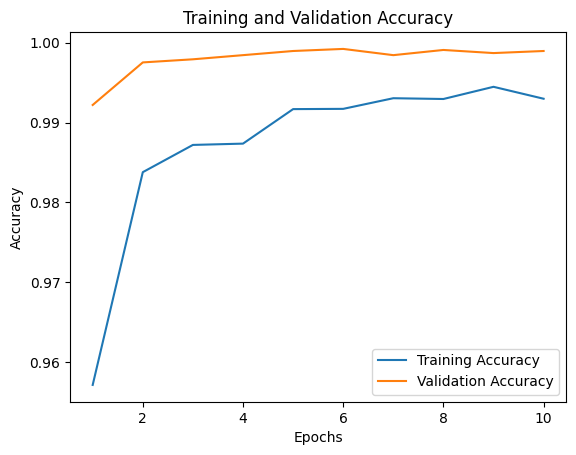

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history3.history['accuracy']
val_accuracy = history3.history['val_accuracy']
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


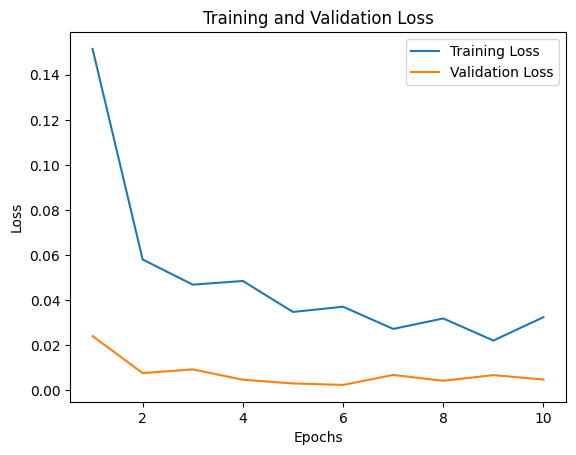

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = ResNet50V2_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


67/67 [==============================] - 5s 65ms/step
Accuracy: 100.0
Precision: 100.0
Recall: 100.0
F1-score: 100.0


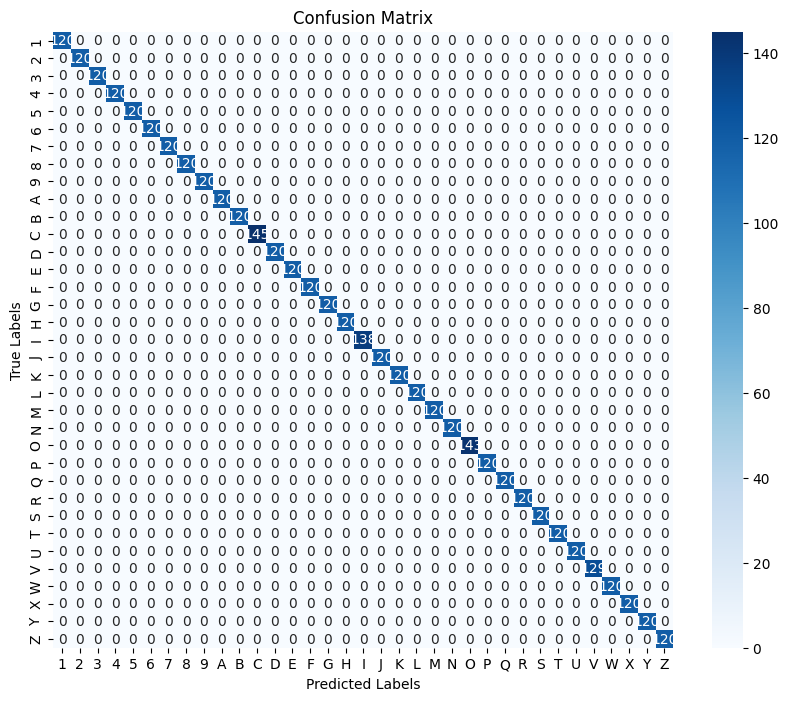

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 2s 2s/step


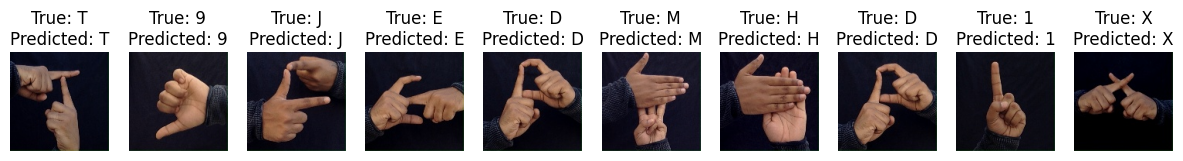

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = ResNet50V2_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# VGG19

In [ ]:
from tensorflow.keras.applications import VGG19
# Load the vgg19 model pre-trained on ImageNet without the top layer
base_model4 = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
# Freeze the convolutional layers
base_model4.trainable = False
# Print model summary
base_model4.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
VGG19_model = models.Sequential([
    base_model4,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(35, activation='softmax')
])

In [ ]:
VGG19_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 35)                17955     
                                                                 
Total params: 24237155 (92.46 MB)
Trainable params: 4212771 (16.07 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
# Define parameters
classes = 35
epochs = 10
learning_rate = 0.0001

# Compile the model
VGG19_model.compile(optimizer=Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history4 = VGG19_model.fit(train_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
481/481 [==============================] - 103s 203ms/step - loss: 0.8515 - accuracy: 0.8360 - val_loss: 0.0890 - val_accuracy: 0.9981
Epoch 2/10
481/481 [==============================] - 96s 200ms/step - loss: 0.1009 - accuracy: 0.9899 - val_loss: 0.0274 - val_accuracy: 0.9990
Epoch 3/10
481/481 [==============================] - 97s 201ms/step - loss: 0.0461 - accuracy: 0.9961 - val_loss: 0.0127 - val_accuracy: 0.9997
Epoch 4/10
481/481 [==============================] - 96s 200ms/step - loss: 0.0286 - accuracy: 0.9976 - val_loss: 0.0076 - val_accuracy: 0.9999
Epoch 5/10
481/481 [==============================] - 97s 201ms/step - loss: 0.0199 - accuracy: 0.9979 - val_loss: 0.0048 - val_accuracy: 0.9999
Epoch 6/10
481/481 [==============================] - 97s 202ms/step - loss: 0.0137 - accuracy: 0.9990 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 7/10
481/481 [==============================] - 96s 200ms/step - loss: 0.0107 - accuracy: 0.9988 - val_loss: 0.0026 - val_a

In [ ]:
VGG19_model.save('35-vgg19-newisl.h5')

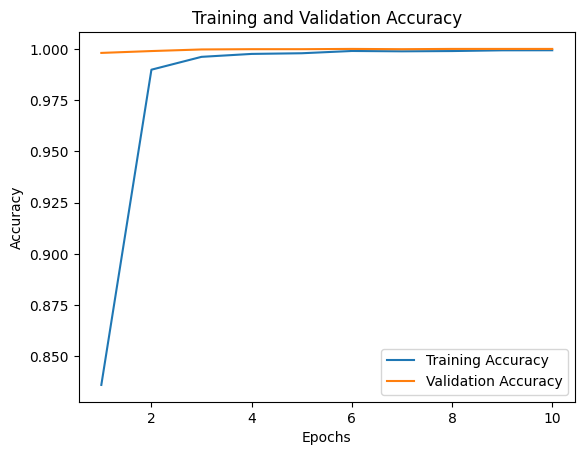

In [ ]:
import matplotlib.pyplot as plt
# Extract training and validation accuracy and loss from history
train_accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
train_loss = history4.history['loss']
val_loss = history4.history['val_loss']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


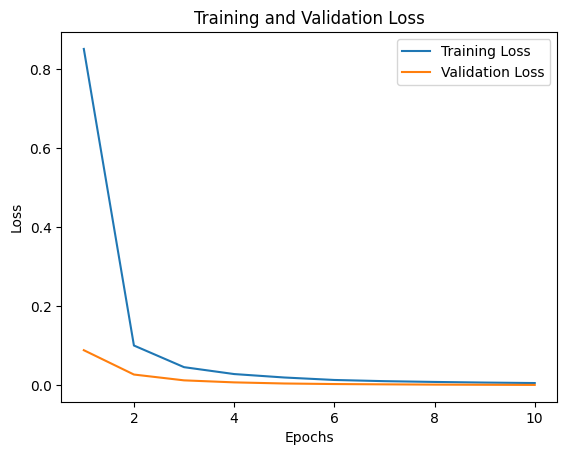

In [ ]:

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Generate predictions on test data
predictions = VGG19_model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels back to categorical labels
true_classes = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)*100
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='weighted')*100
recall = recall_score(true_classes, predicted_classes, average='weighted')*100
f1_score = 2 * (precision * recall) / (precision + recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)


67/67 [==============================] - 11s 161ms/step
Accuracy: 100.0
Precision: 100.0
Recall: 100.0
F1-score: 100.0


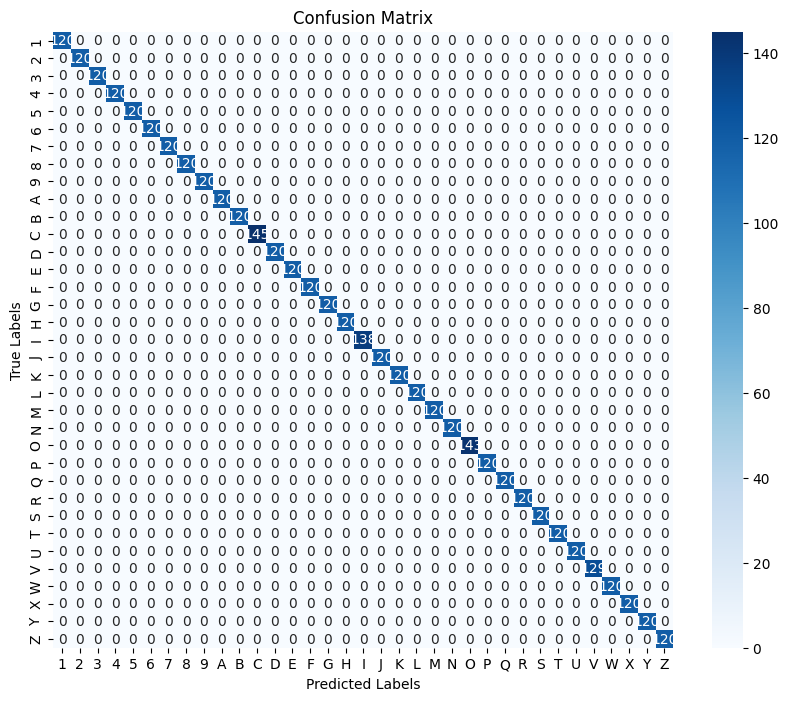

In [ ]:
# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 1s 1s/step


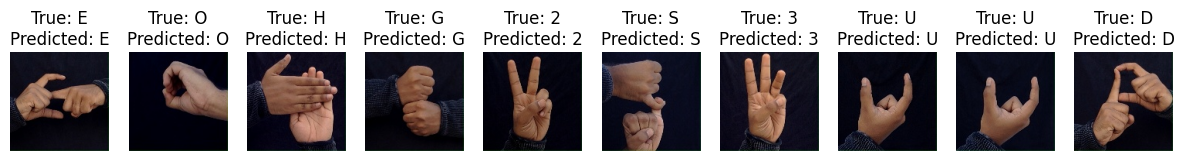

In [ ]:
import random

# Reset test generator to start from the beginning
test_generator.reset()
#print(train_generator.class_indices)
class_names = list(train_generator.class_indices.keys())
# Get a batch of test data
batch = test_generator.next()

# Extract images and labels from the batch
images, labels = batch

# Randomly select a subset of images and their corresponding labels
num_images_to_display = 10  # Adjust the number of images to display
random_indices = random.sample(range(len(images)), num_images_to_display)
selected_images = images[random_indices]
selected_labels = labels[random_indices]

# Make predictions on the selected images
predictions = VGG19_model.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display images with their predicted and true classes
plt.figure(figsize=(15, 3 * num_images_to_display))
for i in range(num_images_to_display):
    # Display the image
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(selected_images[i])

    # Get the true and predicted class names
    true_class = class_names[np.argmax(selected_labels[i])]
    pred_class = class_names[predicted_classes[i]]

    # Set the title with true and predicted classes
    plt.title(f'True: {true_class}\nPredicted: {pred_class}')
    plt.axis('off')

plt.show()

# MODEL COMPARISON

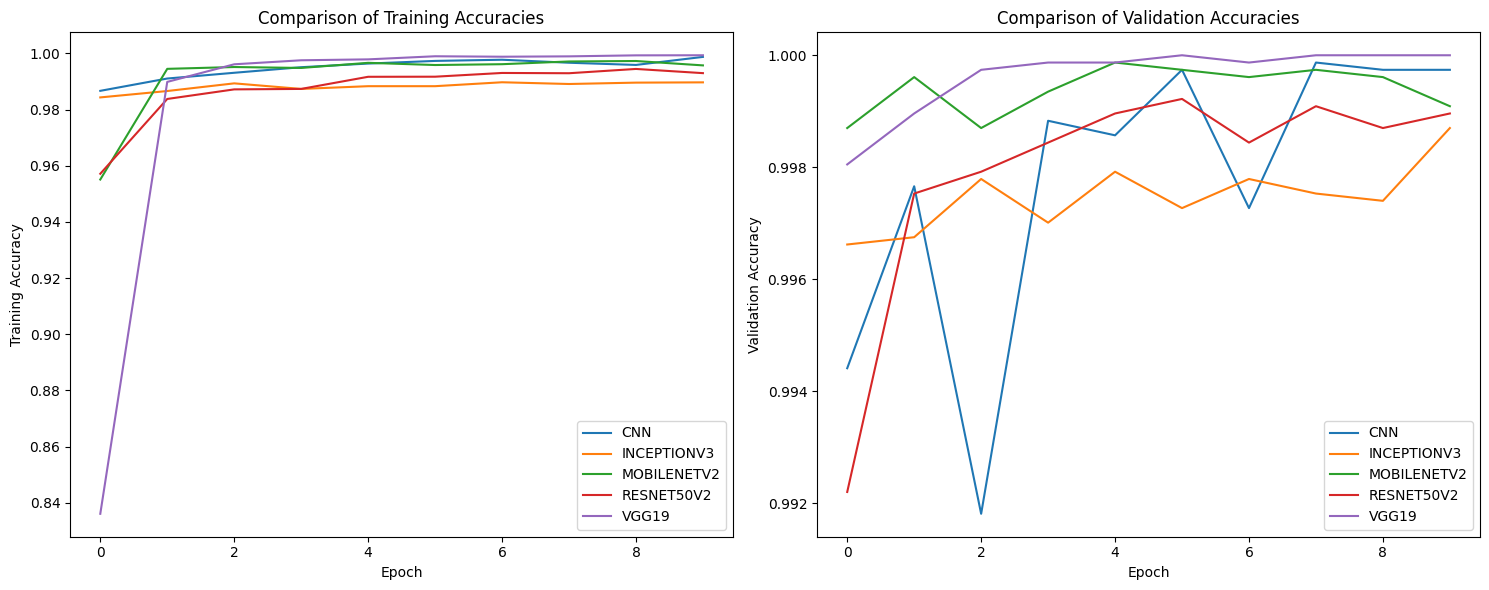

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Plotting the accuracies
plt.figure(figsize=(15, 6))

# Plot training accuracies
plt.subplot(1, 2, 1)
for model, acc in train_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Comparison of Training Accuracies')
plt.legend()

# Plot validation accuracies
plt.subplot(1, 2, 2)
for model, acc in validation_accuracies.items():
    plt.plot(acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Validation Accuracies')
plt.legend()

plt.tight_layout()
plt.show()


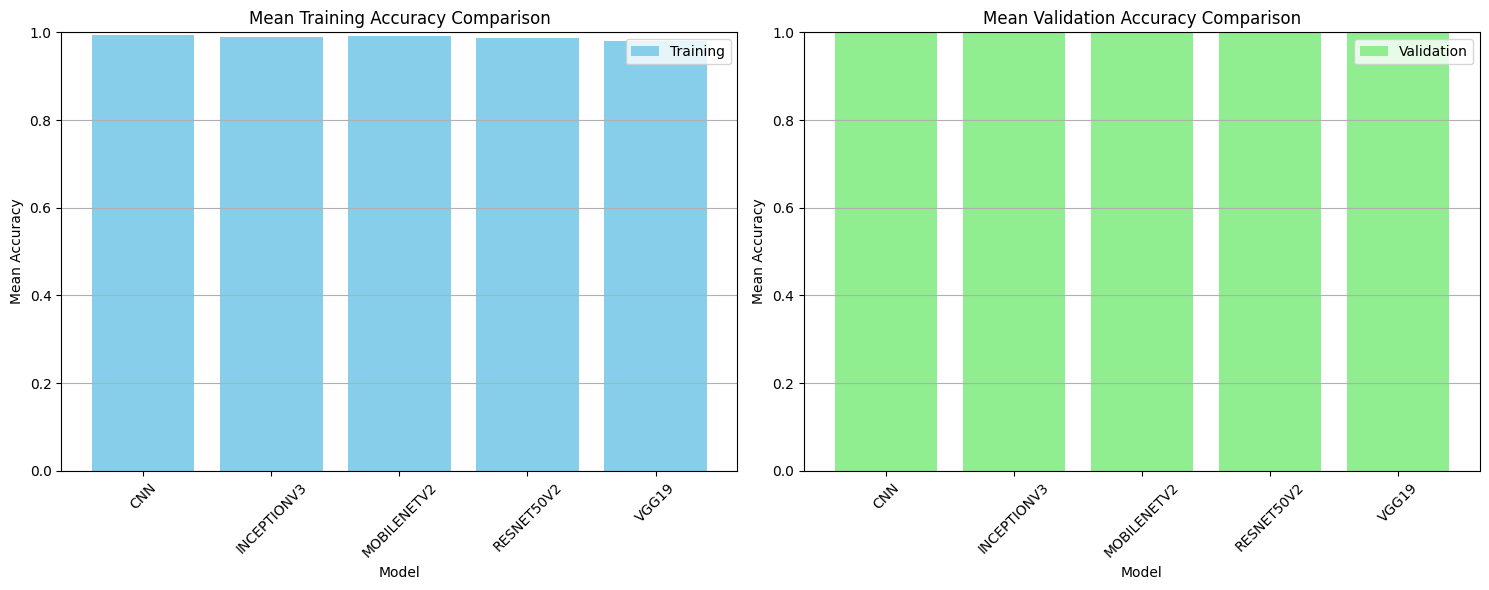

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dictionary to store accuracies
train_accuracies = {}
validation_accuracies = {}

# Extract accuracies from history objects
train_accuracies['CNN'] = history.history['accuracy']
train_accuracies['INCEPTIONV3'] = history1.history['accuracy']
train_accuracies['MOBILENETV2'] = history2.history['accuracy']
train_accuracies['RESNET50V2'] = history3.history['accuracy']
train_accuracies['VGG19'] = history4.history['accuracy']

validation_accuracies['CNN'] = history.history['val_accuracy']
validation_accuracies['INCEPTIONV3'] = history1.history['val_accuracy']
validation_accuracies['MOBILENETV2'] = history2.history['val_accuracy']
validation_accuracies['RESNET50V2'] = history3.history['val_accuracy']
validation_accuracies['VGG19'] = history4.history['val_accuracy']

# Calculate mean accuracies
train_means = [np.mean(acc) for acc in train_accuracies.values()]
validation_means = [np.mean(acc) for acc in validation_accuracies.values()]

# Plotting bar plots for mean training and validation accuracies
plt.figure(figsize=(15, 6))

# Plot mean training accuracies
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(train_accuracies)), train_means, color='skyblue', label='Training')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Training Accuracy Comparison')
plt.xticks(np.arange(len(train_accuracies)), train_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

# Plot mean validation accuracies
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(validation_accuracies)), validation_means, color='lightgreen', label='Validation')
plt.xlabel('Model')
plt.ylabel('Mean Accuracy')
plt.title('Mean Validation Accuracy Comparison')
plt.xticks(np.arange(len(validation_accuracies)), validation_accuracies.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


67/67 [==============================] - 7s 102ms/step - loss: 3.2657e-05 - accuracy: 1.0000


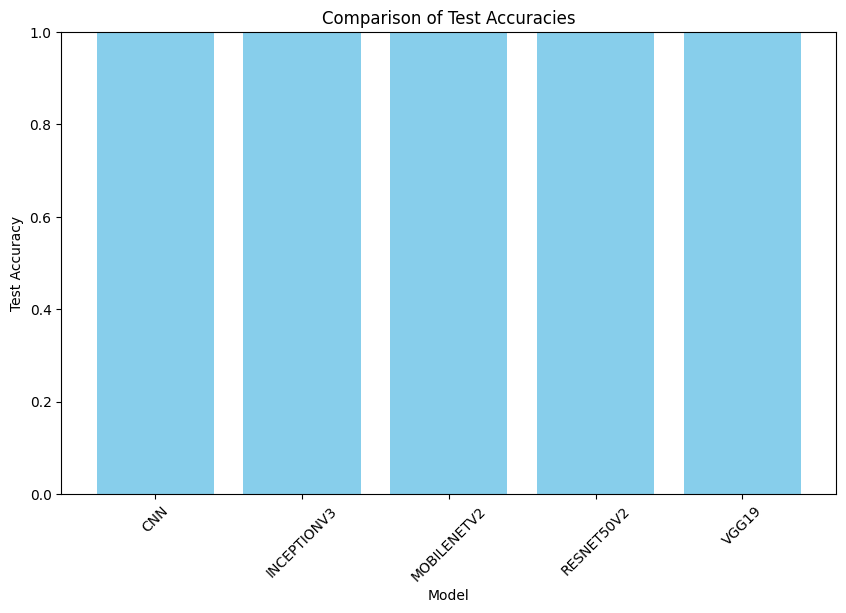

In [ ]:
# Dictionary to store test accuracies
test_accuracies = {}

# Evaluate each model on the test data
test_accuracies['CNN'] = cnn_model.evaluate(test_generator)[1]
test_accuracies['INCEPTIONV3'] = inceptionv3_model.evaluate(test_generator)[1]
test_accuracies['MOBILENETV2'] = MobileNetV2_model.evaluate(test_generator)[1]
test_accuracies['RESNET50V2'] = ResNet50V2_model.evaluate(test_generator)[1]
test_accuracies['VGG19'] = VGG19_model.evaluate(test_generator)[1]

# Plotting the test accuracies
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracies')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()
